### Imports

In [5]:
import pandas
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef, roc_auc_score, roc_curve,auc
from sklearn.cross_validation import cross_val_score, StratifiedKFold
%matplotlib inline

### Functions 

In [11]:
def mcc(tp, tn, fp, fn):
    sup = tp * tn - fp * fn
    inf = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    if inf==0:
        return 0
    else:
        return sup / np.sqrt(inf)

In [12]:
def eval_mcc(y_true, y_prob, show=False):
    idx = np.argsort(y_prob)
    y_true_sort = y_true[idx]
    n = y_true.shape[0]
    nump = 1.0 * np.sum(y_true) # number of positive
    numn = n - nump # number of negative
    tp = nump
    tn = 0.0
    fp = numn
    fn = 0.0
    best_mcc = 0.0
    best_id = -1
    prev_proba = -1
    best_proba = -1
    mccs = np.zeros(n)
    for i in range(n):
        # all items with idx < i are predicted negative while others are predicted positive
        # only evaluate mcc when probability changes
        proba = y_prob[idx[i]]
        if proba != prev_proba:
            prev_proba = proba
            new_mcc = mcc(tp, tn, fp, fn)
            if new_mcc >= best_mcc:
                best_mcc = new_mcc
                best_id = i
                best_proba = proba
        mccs[i] = new_mcc
        if y_true_sort[i] == 1:
            tp -= 1.0
            fn += 1.0
        else:
            fp -= 1.0
            tn += 1.0
    if show:
        y_pred = (y_prob >= best_proba).astype(int)
        score = matthews_corrcoef(y_true, y_pred)
        print(score, best_mcc)
        plt.plot(mccs)
        return best_proba, best_mcc, y_pred
    else:
        return best_mcc

In [13]:
def roundn(y_pred, scale):
    return np.around(y_pred * scale) / scale

In [14]:
def mcc_eval(y_prob, dtrain):
    y_true = dtrain.get_label()
    best_mcc = eval_mcc(y_true, y_prob)
    return 'MCC', best_mcc

### XVal

In [6]:
dtrain = xgb.DMatrix?

In [32]:
dtrain = xgb.DMatrix('train.svm')

In [33]:
params = {'bst:max_depth':2, 'bst:eta':0.1, 'min_child_weight':4, 
         'objective':'binary:logistic'}
params['nthread'] = 4
params['eval_metric'] = 'auc'
params['scale_pos_weight'] = 0.995

In [12]:
xgb.cv?

In [ ]:
xgb.cv(params, dtrain, num_boost_round=50, verbose_eval=True)

### Validation

In [34]:
dtrain_val = xgb.DMatrix('trainsplit.svmaa')
dval = xgb.DMatrix('trainsplit.svmab')

In [77]:
params = {'bst:max_depth':2, 'bst:eta':0.1, 'min_child_weight':16, 
         'objective':'binary:logistic'}
params['nthread'] = 4
params['eval_metric'] = 'auc'
params['scale_pos_weight'] = 0.995

In [78]:
num_round = 40
evallist  = [(dval,'eval')]
bst = xgb.train( params, dtrain_val, num_round, evallist)

[0]	eval-auc:0.595109
[1]	eval-auc:0.595628
[2]	eval-auc:0.64495
[3]	eval-auc:0.658773
[4]	eval-auc:0.666684
[5]	eval-auc:0.66926
[6]	eval-auc:0.6676
[7]	eval-auc:0.6681
[8]	eval-auc:0.666242
[9]	eval-auc:0.669669
[10]	eval-auc:0.677957
[11]	eval-auc:0.68043
[12]	eval-auc:0.679797
[13]	eval-auc:0.680854
[14]	eval-auc:0.682357
[15]	eval-auc:0.682764
[16]	eval-auc:0.684903
[17]	eval-auc:0.686333
[18]	eval-auc:0.688814
[19]	eval-auc:0.689501
[20]	eval-auc:0.690694
[21]	eval-auc:0.689984
[22]	eval-auc:0.688621
[23]	eval-auc:0.685945
[24]	eval-auc:0.685645
[25]	eval-auc:0.685413
[26]	eval-auc:0.685304
[27]	eval-auc:0.684852
[28]	eval-auc:0.685021
[29]	eval-auc:0.684499
[30]	eval-auc:0.684288
[31]	eval-auc:0.684224
[32]	eval-auc:0.683975
[33]	eval-auc:0.683828
[34]	eval-auc:0.683752
[35]	eval-auc:0.683638
[36]	eval-auc:0.683758
[37]	eval-auc:0.684114
[38]	eval-auc:0.683985
[39]	eval-auc:0.684144


0.209049442469 0.209049442469


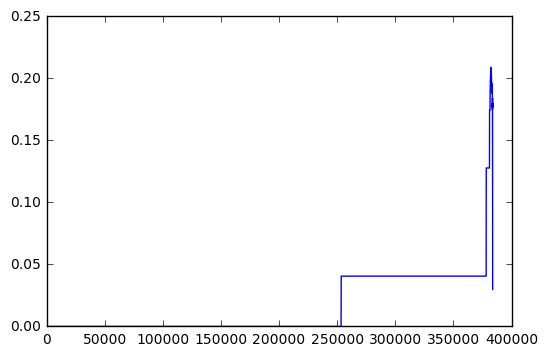

In [79]:
best_proba_val, best_mcc_val, y_pred_val = eval_mcc(dval.get_label(), roundn(bst.predict(dval), 100), show=True)

Check ratio of positive in predictions

In [69]:
y_pred_val.sum()/y_pred_val.size

0.0044716961956705855

Check ration of positive in true labels

In [61]:
label=dval.get_label()
label.sum()/label.size

0.0058163321146484535

In [80]:
best_proba_val

0.079999998

### Test

In [81]:
num_round=40
bst = xgb.train( params, dtrain, num_round)

In [42]:
dtest = xgb.DMatrix('test.svm')

In [82]:
y_pred_test=roundn(bst.predict(dtest), 100)

In [83]:
results=(y_pred_test >= best_proba_val).astype(int)

In [84]:
results.sum()/results.size

0.0047493216461611766

In [85]:
IDs=pandas.read_csv('Ids.txt')

In [86]:
IDs['Response']=results

In [87]:
IDs.head()

,Id,Response
0,1,0
1,2,0
2,3,0
3,5,0
4,8,0


In [88]:
IDs.to_csv('results.csv', index=False)